In [32]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [33]:
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_test.csv')

train = train.drop(['TR','AG'],1)
test = test.drop(['TR','AG'],1)
val = val.drop(['TR','AG'],1)

/tmp/ipykernel_4745/157768247.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR','AG'],1)
/tmp/ipykernel_4745/157768247.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR','AG'],1)
/tmp/ipykernel_4745/157768247.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR','AG'],1)


<AxesSubplot:xlabel='HS', ylabel='count'>

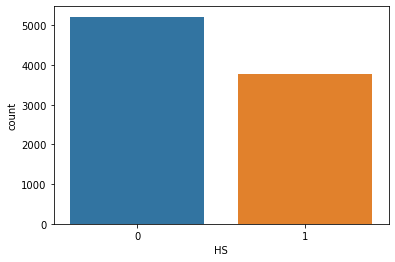

In [34]:
sns.countplot(data=train,x='HS')

Unbalanced but not massively

Fasttext model. tokenizer->fast text embedding ->LSTM->Linear->linear->softmax

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [36]:
def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    y = data['HS']
    return X, y

In [37]:
#Split x and ys
x_train, y_train = x_y_split(train)

In [38]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(x_train)
def tokenize_and_pad(x_data,tokenizer=tokenizer,length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data,maxlen=length)
    return x_data
x_train = tokenize_and_pad(x_train,tokenizer)
def split_and_tokenize(data,tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y

In [39]:
x_val , y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)

In [40]:
embed_dim = 128
lstm_out = 196
input_length=x_train.shape[1]
model = Sequential()
##TODO replace with fasttext
model.add(Embedding(max_features,embed_dim,input_length=input_length))
model.add(LSTM(lstm_out))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='softmax'))
model.compile(loss=BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 57, 128)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25216     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 936,657
Trainable params: 936,657
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
filepath = 'checkpoints/test.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks = [checkpoint]

history = model.fit(x=x_train,
                    y=y_train,batch_size=32,
                    validation_data=(x_val,y_val),
                    epochs=5,
                    callbacks=callbacks)

Epoch 1/5
282/282 [==============================] - 3s 8ms/step - loss: 0.5719 - accuracy: 0.4215 - val_loss: 1.3071 - val_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 1.30708, saving model to checkpoints/test.hdf5
Epoch 2/5
282/282 [==============================] - 2s 7ms/step - loss: 0.3678 - accuracy: 0.4174 - val_loss: 1.8106 - val_accuracy: 0.4200

Epoch 00002: val_loss did not improve from 1.30708
Epoch 3/5
282/282 [==============================] - 2s 7ms/step - loss: 0.2660 - accuracy: 0.4257 - val_loss: 2.4809 - val_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.30708
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 0.1907 - accuracy: 0.4265 - val_loss: 3.2470 - val_accuracy: 0.4200

Epoch 00004: val_loss did not improve from 1.30708
Epoch 5/5
282/282 [==============================] - 2s 7ms/step - loss: 0.1223 - accuracy: 0.4206 - val_loss: 4.2629 - val_accuracy: 0.4200

Epoch 00005: val_loss did not improve from 1.30

In [42]:
def plot_accuracy_loss_chart(history,epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

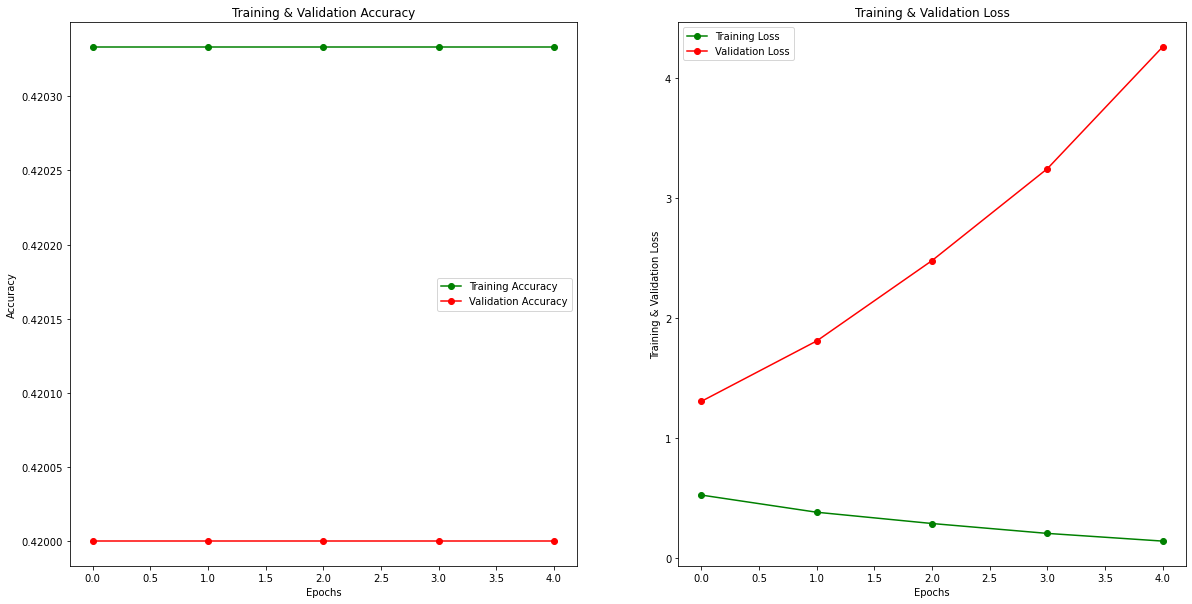

In [43]:
plot_accuracy_loss_chart(history,5)